<a href="https://colab.research.google.com/github/eruru0411/git-test/blob/master/kaggle_titanic_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Kaggle Titanic 생존률 예측

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [23]:
df=pd.read_csv("train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [24]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [26]:
#Target feature 선정
X = df.drop("Survived", axis=1)
y = df["Survived"]
print(X.head())
print(y.head())

   PassengerId  Pclass  ... Cabin Embarked
0            1       3  ...   NaN        S
1            2       1  ...   C85        C
2            3       3  ...   NaN        S
3            4       1  ...  C123        S
4            5       3  ...   NaN        S

[5 rows x 11 columns]
0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64


#### Object 처리

In [27]:
X["Sex"]=X["Sex"].apply(lambda x:0 if x=="female" else 1) #여자 0, 남자 1
print(X["Sex"].head())

0    1
1    0
2    0
3    0
4    1
Name: Sex, dtype: int64


#### 결측처리 
1. 삭제
2. 대체
3. 예측

In [28]:
#결측데이터 확인
print(X.isnull().sum()) #age 177/ Cabin 687, embarked 2건의 null 데이터 확인 -> Cabin은 결측이 너무 많아서(687건) 삭제. 

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [29]:
#나이 예측하기 위해 이름의 호칭 추출 
X["Name2"] = X["Name"].str.extract("([A-Za-z]+)\.")
X["Name2"].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Jonkheer      1
Lady          1
Mme           1
Sir           1
Countess      1
Capt          1
Don           1
Ms            1
Name: Name2, dtype: int64

In [30]:
#Mr.Miss.Mrs.Master.Other로 분류
X["Name2"].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)
X["Name2"].value_counts()

Mr        529
Miss      186
Mrs       127
Master     40
Other       9
Name: Name2, dtype: int64

In [31]:
X.groupby("Name2")["Age"].mean()

Name2
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

In [32]:
#위에서 구한 Age 평균 값을 결측 데이터 값에 대입
X.loc[(X.Age.isnull())&(X.Name2=='Mr'), 'Age'] = 33
X.loc[(X.Age.isnull())&(X.Name2=='Mrs'), 'Age'] = 36
X.loc[(X.Age.isnull())&(X.Name2=='Miss'), 'Age'] = 22
X.loc[(X.Age.isnull())&(X.Name2=='Master'), 'Age'] = 5
X.loc[(X.Age.isnull())&(X.Name2=='Other'), 'Age'] = 46

In [33]:
X.Age.isnull().sum()

0

In [34]:
#나이 구간화 
X["Age_cate"] = X["Age"].apply(lambda x: int(x//10))
X["Age_cate"]

0      2
1      3
2      2
3      3
4      3
      ..
886    2
887    1
888    2
889    2
890    3
Name: Age_cate, Length: 891, dtype: int64

In [35]:
print(pd.crosstab([X["Pclass"] ,X["Sex"], X["Age_cate"]], y).T)
#생존률 : 1등급>2등급>3등급 / 여자>남자

Pclass    1                                  ...  3                                 
Sex       0                         1        ...  0      1                          
Age_cate  0   1   2   3   4   5  6  0  1  2  ...  4  6   0   1   2    3   4  5  6  7
Survived                                     ...                                    
0         1   0   1   0   0   1  0  0  3  9  ...  9  0  15  38  86  128  23  6  2  2
1         0  13  16  35  13  11  3  2  2  9  ...  0  1  10   4  16   15   2  0  0  0

[2 rows x 44 columns]


In [36]:
print(pd.crosstab(X["Embarked"],y).T)
print(pd.crosstab(X["Embarked"],X["Pclass"]).T) 
#S에서 압도적으로 죽은 사람이 많은 것은 맞지만 S에서 탔다고 죽었다고 보긴 어려움. Embarked와 생존여부엔 큰 차이가 없어보임

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217
Embarked   C   Q    S
Pclass               
1         85   2  127
2         17   3  164
3         66  72  353


In [37]:
#SibSP,Parch 병합
X["SP"] = X["SibSp"] + X["Parch"]
print(X[["SP", "SibSp", "Parch"]])

     SP  SibSp  Parch
0     1      1      0
1     1      1      0
2     0      0      0
3     1      1      0
4     0      0      0
..   ..    ...    ...
886   0      0      0
887   0      0      0
888   3      1      2
889   0      0      0
890   0      0      0

[891 rows x 3 columns]


In [38]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
 11  Name2        891 non-null    object 
 12  Age_cate     891 non-null    int64  
 13  SP           891 non-null    int64  
dtypes: float64(2), int64(7), object(5)
memory usage: 97.6+ KB
None


In [39]:
# 컬럼 삭제 
replace_col = ["SibSp", "Parch", "Name", "Name2", "Age"] #대체 컬럼 삭제
del_col = ["PassengerId", "Ticket", "Fare", "Cabin", "Embarked"] #분석에 필요없는 컬럼 삭제
drop_col = replace_col + del_col
X.drop(drop_col, axis=1, inplace=True)
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Pclass    891 non-null    int64
 1   Sex       891 non-null    int64
 2   Age_cate  891 non-null    int64
 3   SP        891 non-null    int64
dtypes: int64(4)
memory usage: 28.0 KB
None


#### 상관분석 
- target 변수에 영향을 주는 주요 feature 확인 -> 분석 예측도 높임
- 중복+불필요한 변수 제거, 다중공선 제거 => 모델 복잡도를 낮춤
- 성능 개선 

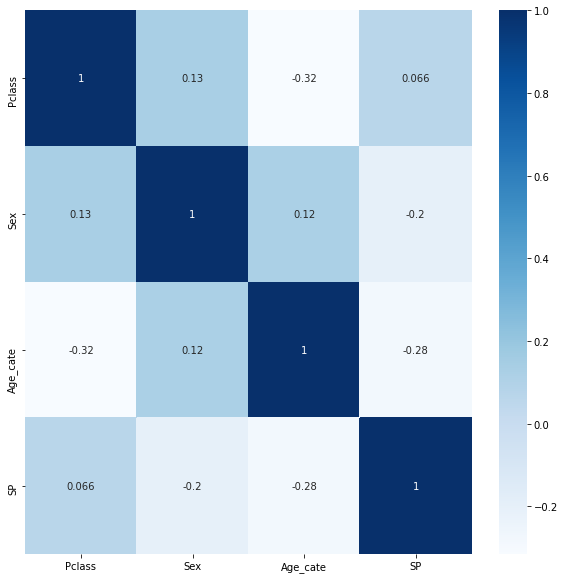

In [41]:
head_df = X.copy()
head_df["Serv"] = y
plt.figure(figsize=(10,10))
sns.heatmap(data=X.corr(), annot=True, fmt=".2g", cmap="Blues")

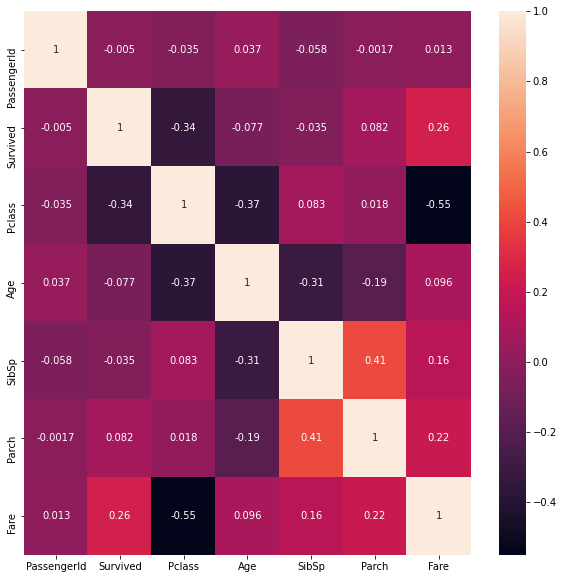

In [42]:
plt.figure(figsize=(10,10))
sns.heatmap(data=df.corr(), annot=True, fmt=".2g")
#Pclassd와 survived 관계 있어 보임, Pclass와 fare?

#### 분석 (모델선정 / 평가척도/ 검증)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=121, shuffle=True)

from sklearn.tree import DecisionTreeClassifier #의사결정트리
from sklearn.neighbors import KNeighborsClassifier #이웃노드 분류
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score  #정확도 평가
from sklearn.ensemble import RandomForestClassifier #랜덤포레스트

dt_model = DecisionTreeClassifier()
knn_model = KNeighborsClassifier()
rf_model = RandomForestClassifier()

models = [dt_model, knn_model, rf_model]

for model in models :
  #fit : 학습
  model.fit(X_train, y_train)
  #predict : 시험
  y_pred=model.predict(X_test)
  #score : 예측 정확도 확인
  score = accuracy_score(y_test, y_pred)
  
  print(model.__class__, ":", score)
  print(X.head())

<class 'sklearn.tree._classes.DecisionTreeClassifier'> : 0.7932960893854749
   Pclass  Sex  Age_cate  SP
0       3    1         2   1
1       1    0         3   1
2       3    0         2   0
3       1    0         3   1
4       3    1         3   0
<class 'sklearn.neighbors._classification.KNeighborsClassifier'> : 0.7541899441340782
   Pclass  Sex  Age_cate  SP
0       3    1         2   1
1       1    0         3   1
2       3    0         2   0
3       1    0         3   1
4       3    1         3   0
<class 'sklearn.ensemble._forest.RandomForestClassifier'> : 0.7988826815642458
   Pclass  Sex  Age_cate  SP
0       3    1         2   1
1       1    0         3   1
2       3    0         2   0
3       1    0         3   1
4       3    1         3   0


#####분석(예측)력을 저해하는 원인
1. 피쳐가 많은 경우 --> 모델의 복잡도가 증가하는 경우(overfitting<-->underfitting)
2. 수치가 큰 경우 --> log,scailing
3. 결측데이터(null) --> isnull(),fillna()
4. 이상치(outlier) --> 협의 후 삭제/대체 (boxplot, histogram, scatter로 확인)
5. 데이터가 편중 --> 정규분포화
6. 피쳐가공 (Object-->변환, unique한 일련번호x, 구간(범주)화, OneHot인코딩)
7. 데이터가 적은 경우 --> 데이터 증강
8. 모델이 적절하지 않은 경우 --> 다른 모델 사용

In [44]:
#결측 데이터 확인
print(X.isnull().sum()) #null값 없는 것 확인

Pclass      0
Sex         0
Age_cate    0
SP          0
dtype: int64


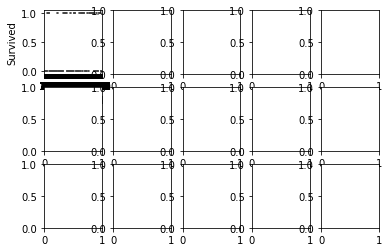

In [46]:
#이상치 확인
fig, axes = plt.subplots(nrows=3, ncols=5)
columns = df.columns
for i, col in enumerate(columns) :
  r = int(i/5)
  c = i % 5
  sns.boxplot(x=col, y='Survived', data=df, ax=axes[r][c])
  plt.show()

In [47]:
#IQR : 25~75%의 범위 값
def get_outlier(df=None, column=None):
  Q1 = np.percentile(df[column].values, 25)
  Q3 = np.percentile(df[column].values, 75)
  IQR = Q3 - Q1
  IQR_weight = IQR * 1.5
  minimum = Q1 - IQR_weight
  maximum = Q3 + IQR_weight
  outlier_idx = df[column][(df[column] < minimum) | df[column] > maximum].index
  return outlier_idx

In [50]:
numeric_columns = df.dtypes[df.dtypes!='object'].index #object를 뺀 컬럼값만 돌려받기
for i, col in enumerate(numeric_columns) :
  outlier_idx = get_outlier(df=df, column=col)
  print(col, outlier_idx) #여기서는 outlier안 지우고 하겠음(데이터가 너무 빈약해질 수 있어서..)

PassengerId Int64Index([], dtype='int64')
Survived Int64Index([], dtype='int64')
Pclass Int64Index([], dtype='int64')
Age Int64Index([], dtype='int64')
SibSp Int64Index([], dtype='int64')
Parch Int64Index([  7,   8,  10,  13,  16,  24,  25,  27,  43,  50,
            ...
            855, 856, 858, 863, 869, 871, 879, 880, 885, 888],
           dtype='int64', length=213)
Fare Int64Index([], dtype='int64')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6bb7e2fa20>,
      dtype=object)

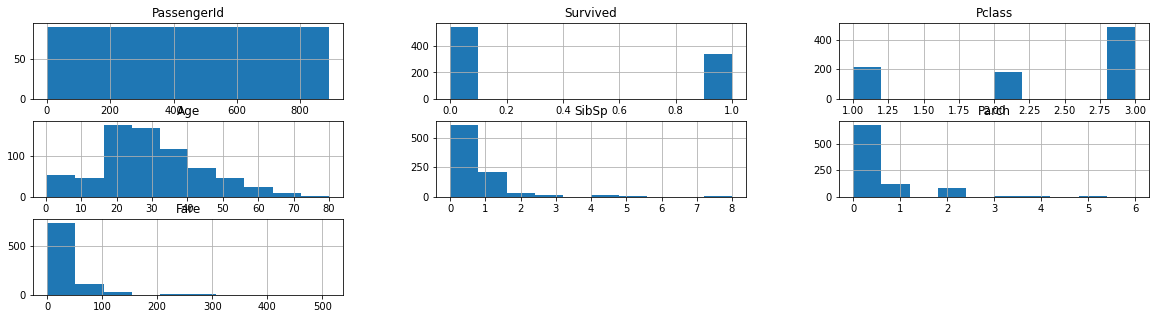

In [51]:
#데이터가 편중 --> 정규분포화
df.hist(figsize=(20,5))

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

scaler = StandardScaler()

X_scaler = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaler, y, test_size=0.2, random_state=121, shuffle=True)
models = [dt_model, knn_model, rf_model]

for model in models :
  #fit : 학습
  model.fit(X_train, y_train)
  #predict : 시험
  y_pred=model.predict(X_test)
  #score : 예측 정확도 확인
  score = accuracy_score(y_test, y_pred)
  
  print(model.__class__, ":", score)
  print(X.head())

<class 'sklearn.tree._classes.DecisionTreeClassifier'> : 0.7932960893854749
   Pclass  Sex  Age_cate  SP
0       3    1         2   1
1       1    0         3   1
2       3    0         2   0
3       1    0         3   1
4       3    1         3   0
<class 'sklearn.neighbors._classification.KNeighborsClassifier'> : 0.7653631284916201
   Pclass  Sex  Age_cate  SP
0       3    1         2   1
1       1    0         3   1
2       3    0         2   0
3       1    0         3   1
4       3    1         3   0
<class 'sklearn.ensemble._forest.RandomForestClassifier'> : 0.7932960893854749
   Pclass  Sex  Age_cate  SP
0       3    1         2   1
1       1    0         3   1
2       3    0         2   0
3       1    0         3   1
4       3    1         3   0


In [53]:
# 6. 피쳐가공 (Object-->변환, unique한 일련번호x, 구간(범주)화, OneHot인코딩)
print(X["Age_cate"].head())

0    2
1    3
2    2
3    3
4    3
Name: Age_cate, dtype: int64


In [54]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Pclass    891 non-null    int64
 1   Sex       891 non-null    int64
 2   Age_cate  891 non-null    int64
 3   SP        891 non-null    int64
dtypes: int64(4)
memory usage: 28.0 KB
None


In [55]:
X_encoding = pd.get_dummies(data=X, columns=["Age_cate"], prefix="OH_Age_cate", drop_first=False)
print(X_encoding.info())
print(X_encoding.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Pclass         891 non-null    int64
 1   Sex            891 non-null    int64
 2   SP             891 non-null    int64
 3   OH_Age_cate_0  891 non-null    uint8
 4   OH_Age_cate_1  891 non-null    uint8
 5   OH_Age_cate_2  891 non-null    uint8
 6   OH_Age_cate_3  891 non-null    uint8
 7   OH_Age_cate_4  891 non-null    uint8
 8   OH_Age_cate_5  891 non-null    uint8
 9   OH_Age_cate_6  891 non-null    uint8
 10  OH_Age_cate_7  891 non-null    uint8
 11  OH_Age_cate_8  891 non-null    uint8
dtypes: int64(3), uint8(9)
memory usage: 28.8 KB
None
   Pclass  Sex  SP  ...  OH_Age_cate_6  OH_Age_cate_7  OH_Age_cate_8
0       3    1   1  ...              0              0              0
1       1    0   1  ...              0              0              0
2       3    0   0  ...              0        

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_encoding, y, test_size=0.2, random_state=121, shuffle=True)
models = [dt_model, knn_model, rf_model]

for model in models :
  #fit : 학습
  model.fit(X_train, y_train)
  #predict : 시험
  y_pred=model.predict(X_test)
  #score : 예측 정확도 확인
  score = accuracy_score(y_test, y_pred)
  
  print(model.__class__, ":", score)
  print(X.head())

<class 'sklearn.tree._classes.DecisionTreeClassifier'> : 0.7877094972067039
   Pclass  Sex  Age_cate  SP
0       3    1         2   1
1       1    0         3   1
2       3    0         2   0
3       1    0         3   1
4       3    1         3   0
<class 'sklearn.neighbors._classification.KNeighborsClassifier'> : 0.7597765363128491
   Pclass  Sex  Age_cate  SP
0       3    1         2   1
1       1    0         3   1
2       3    0         2   0
3       1    0         3   1
4       3    1         3   0
<class 'sklearn.ensemble._forest.RandomForestClassifier'> : 0.7932960893854749
   Pclass  Sex  Age_cate  SP
0       3    1         2   1
1       1    0         3   1
2       3    0         2   0
3       1    0         3   1
4       3    1         3   0


#### 평가 matrix

In [57]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [61]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=121)
kf = KFold(n_splits=5, shuffle=True, random_state=121)

accuracy_score_list = []
f1_score_list = []

for i, (idx_train, idx_test) in enumerate (kf.split(X)):
  X_train, X_test = X.iloc[idx_train], X.iloc[idx_test]
  y_train, y_test = y.iloc[idx_train], y.iloc[idx_test]

  rf_model.fit(X_train, y_train)
  y_pred = rf_model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  accuracy_score_list.append(accuracy)
  f1_score_list.append(f1)
  print(i, ":", accuracy, f1)

0 : 0.7988826815642458 0.7230769230769231
1 : 0.8314606741573034 0.7580645161290323
2 : 0.8258426966292135 0.752
3 : 0.8595505617977528 0.8
4 : 0.797752808988764 0.76
